# Packages & Functions

## Packages

In [29]:
import os
import time
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.optim.adam import Adam
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Functions

In [30]:
def scailing(x, y):

    ms = MinMaxScaler()
    ss = StandardScaler()

    x_ss = ss.fit_transform(x)
    y_ms = ms.fit_transform(y)

    return x_ss, y_ms

In [31]:
def window_sliding(x, y, step):
    
    x_ws, y_ws = list(), list()
    for i in range(len(df)):
        x_end = i + step
        y_end = x_end + 1
        
        if y_end > len(df):
            break
        
        tx = x[i:x_end, :]
        ty = y[x_end:y_end, :]
        
        x_ws.append(tx)
        y_ws.append(ty)
        
    return torch.FloatTensor(x_ws).to(device), torch.FloatTensor(y_ws).to(device).view([-1, 1])

In [32]:
def plotting(train_loader, test_loader, actual):
    with torch.no_grad():
        train_pred = []
        test_pred = []

        for data in train_loader:
            seq, target = data
            out = model(seq)
            train_pred += out.cpu().numpy().tolist()

        for data in test_loader:
            seq, target = data
            out = model(seq)
            test_pred += out.cpu().numpy().tolist()
      
    total = train_pred + test_pred
    plt.figure(figsize=(20,10))
    plt.plot(np.ones(100)*len(train_pred), np.linspace(0,1,100), '--', linewidth=0.6)
    plt.plot(actual, '--')
    plt.plot(total, 'b', linewidth=0.6)

    plt.legend(['train boundary', 'actual', 'prediction'])
    plt.show()


# Data Processing

## Load Data

In [33]:
data = pd.read_csv('../Data/train.csv')
print(data.dtypes)

Date      object
Open       int64
High       int64
Low        int64
Volume     int64
Close      int64
dtype: object


## Index & Col

In [34]:
df = data.loc[:, ['Date', 'Open']]
df.rename(columns = {'Open':'AC'}, inplace = True)
df['DAC'] = df['AC'] - df['AC'].shift(1)
df['DDAC'] = df['DAC'] - df['DAC'].shift(1)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace = True)

In [35]:
df

,AC,DAC,DDAC
Date,,,
2015-12-16,120,NaN,NaN
2015-12-17,124,4.0,NaN
2015-12-18,121,-3.0,-7.0
2015-12-21,120,-1.0,2.0
2015-12-22,117,-3.0,-2.0
...,...,...,...
2019-10-14,284,-1.0,-20.0
2019-10-15,284,0.0,1.0
2019-10-16,283,-1.0,-1.0


## Null Values

In [36]:
df.isnull().sum()

AC      0
DAC     1
DDAC    2
dtype: int64

In [37]:
df.dropna(inplace = True)
df

,AC,DAC,DDAC
Date,,,
2015-12-18,121,-3.0,-7.0
2015-12-21,120,-1.0,2.0
2015-12-22,117,-3.0,-2.0
2015-12-23,117,0.0,3.0
2015-12-24,118,1.0,1.0
...,...,...,...
2019-10-14,284,-1.0,-20.0
2019-10-15,284,0.0,1.0
2019-10-16,283,-1.0,-1.0


## Split Target

In [38]:
x = df.iloc[:, 0:]
y = df.iloc[:,:1]
print(x)
print(y)

             AC   DAC  DDAC
Date                       
2015-12-18  121  -3.0  -7.0
2015-12-21  120  -1.0   2.0
2015-12-22  117  -3.0  -2.0
2015-12-23  117   0.0   3.0
2015-12-24  118   1.0   1.0
...         ...   ...   ...
2019-10-14  284  -1.0 -20.0
2019-10-15  284   0.0   1.0
2019-10-16  283  -1.0  -1.0
2019-10-17  304  21.0  22.0
2019-10-18  289 -15.0 -36.0

[965 rows x 3 columns]
             AC
Date           
2015-12-18  121
2015-12-21  120
2015-12-22  117
2015-12-23  117
2015-12-24  118
...         ...
2019-10-14  284
2019-10-15  284
2019-10-16  283
2019-10-17  304
2019-10-18  289

[965 rows x 1 columns]


## Scailing

In [39]:
ms = MinMaxScaler()
ss = StandardScaler()

x_ss = ss.fit_transform(x)
y_ms = ms.fit_transform(y)

In [40]:
x_ss, y_ms

(array([[-0.98782528, -0.46905606, -0.69755913],
        [-0.99740329, -0.17321351,  0.20183235],
        [-1.02613732, -0.46905606, -0.19789719],
        ...,
        [ 0.56381226, -0.17321351, -0.09796481],
        [ 0.76495046,  3.0810545 ,  2.20048009],
        [ 0.62128032, -2.24411134, -3.59559834]]),
 array([[0.11764706],
        [0.11470588],
        [0.10588235],
        [0.10588235],
        [0.10882353],
        [0.10588235],
        [0.10882353],
        [0.11176471],
        [0.10294118],
        [0.08235294],
        [0.08529412],
        [0.07058824],
        [0.10294118],
        [0.10294118],
        [0.09117647],
        [0.10294118],
        [0.09705882],
        [0.07352941],
        [0.06176471],
        [0.07647059],
        [0.08235294],
        [0.07941176],
        [0.07058824],
        [0.05588235],
        [0.05588235],
        [0.04705882],
        [0.03823529],
        [0.03235294],
        [0.03235294],
        [0.04411765],
        [0.03235294],
        [

In [41]:
x = x.to_numpy()
y = y.to_numpy()
x, y = window_sliding(x, y, 60)
x_ss, y_ms = window_sliding(x_ss, y_ms, 60)

In [42]:
x_train = x_ss[:650]
y_train = y_ms[:650]
x_test = x_ss[650:]
y_test = y_ms[650:]
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

torch.Size([650, 60, 3])
torch.Size([650, 1])
torch.Size([255, 60, 3])
torch.Size([255, 1])


In [43]:
train = torch.utils.data.TensorDataset(x_train, y_train)
test = torch.utils.data.TensorDataset(x_test, y_test)

batch_size = 32
train_loader = torch.utils.data.DataLoader(dataset = train, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(dataset = test, batch_size = batch_size, shuffle = False)

# Model

## Define Model

In [44]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, sequence_length, num_layers, dropout, device):
        super(RNN, self).__init__()
        self.device = device
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first = True, dropout = 0.3)
        self.fc1 = nn.Linear(hidden_size * sequence_length, 64)
        self.fc2 = nn.Linear(64, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
        out, hn = self.rnn(x, h0)
        out = out.reshape(out.shape[0], -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = torch.flatten(out)
        return out

In [45]:
input_size = x_ss.size(2)
num_layers = 1
hidden_size = 8
sequence_length = 60

In [46]:
model = RNN(input_size = input_size,
           hidden_size = hidden_size,
           sequence_length = sequence_length,
           num_layers = num_layers, 
           dropout = 0.3, 
           device = device).to(device)

criterion = nn.MSELoss()
lr = 1e-4
num_epochs = 1000
optimizer = Adam(model.parameters(), lr = lr)
patience = 10

## Training

In [47]:
loss_list = []
n = len(train_loader)

for epoch in range(num_epochs):
    running_loss = 0.0
    
    for data in train_loader:
        seq, target = data
        out = model(seq)
        loss = criterion(out, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    loss_list.append(running_loss/n)
    if (epoch+1) % 100 == 0:
        print('epoch: %d loss: %.4f'%(epoch+1, running_loss/n))
        
    if (epoch % patience == 0) & (epoch != 0):
            
            if loss_list[epoch-patience] < loss_list[epoch]:
                print('\n Early Stopping / epoch: %d loss: %.4f'%(epoch+1, running_loss/n))
                
                break


 Early Stopping / epoch: 81 loss: 0.0040


## Visualize Loss Graph

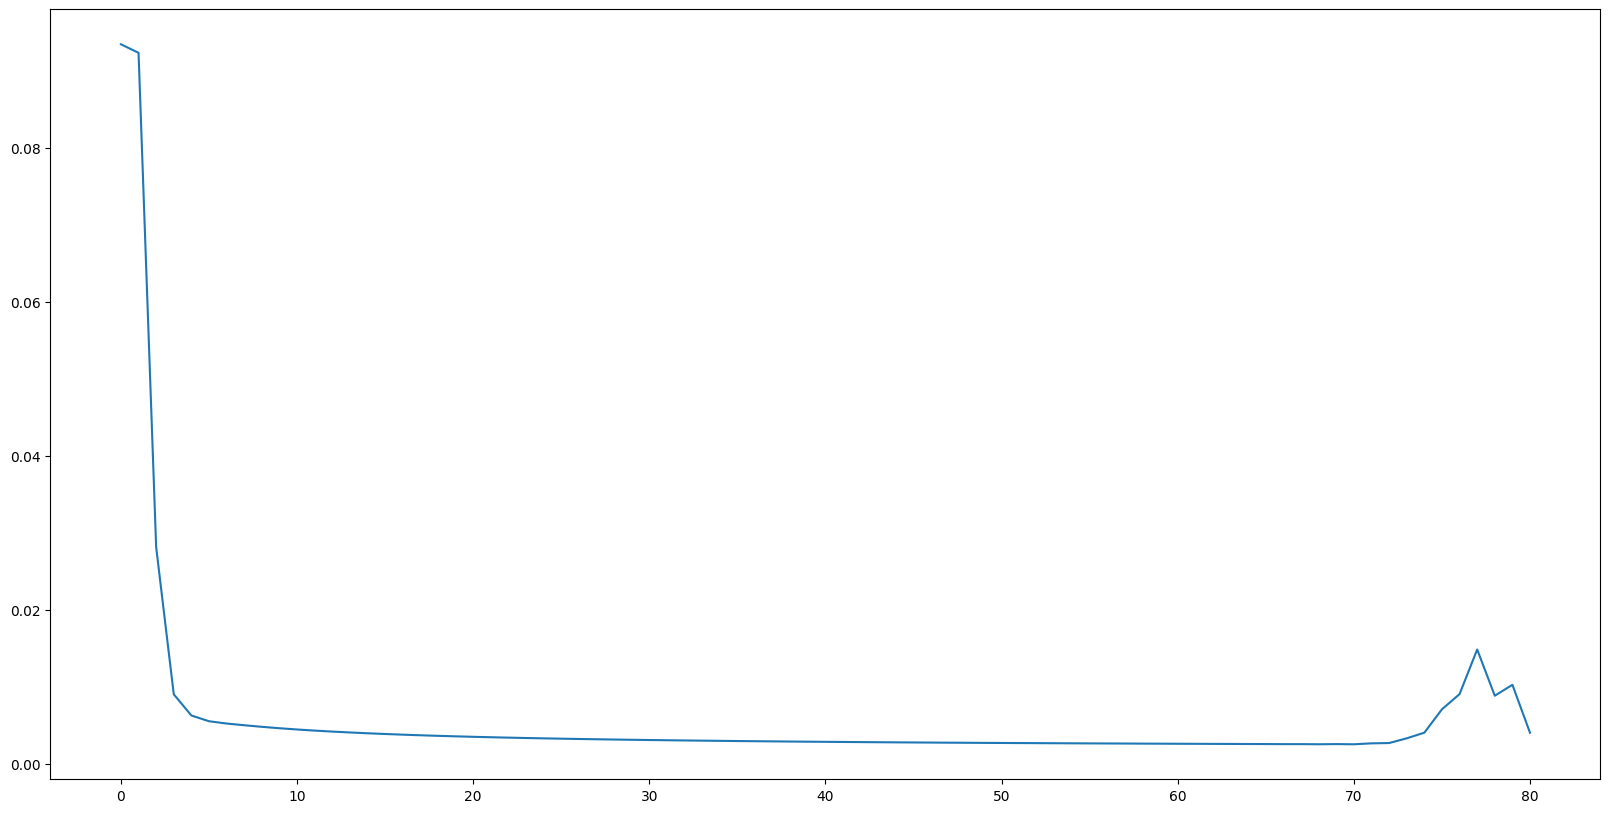

In [48]:
plt.figure(figsize = (20, 10))
plt.plot(loss_list)
plt.show()

## Model Save and Load

In [49]:
PATH = "./Timeseries_RNN_COVID-19_daily_.pth"
torch.save(model.state_dict(), PATH)

In [50]:
PATH = "./Timeseries_RNN_COVID-19_daily_.pth"
model = RNN(input_size = input_size,
           hidden_size = hidden_size,
           sequence_length = sequence_length,
           num_layers = num_layers,
           dropout = 0.3, 
           device = device).to(device)
model.load_state_dict(torch.load(PATH), strict=False)
model.eval()

RNN(
  (rnn): RNN(3, 8, batch_first=True, dropout=0.3)
  (fc1): Linear(in_features=480, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)

## Visualize and Compare predicted values with actual values

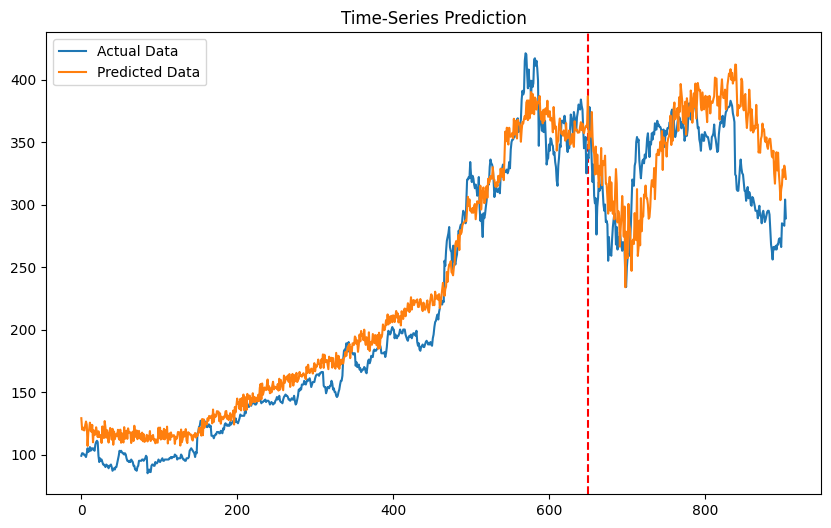

In [51]:
train_predict = model(x_ss)
predicted = train_predict.cpu().data.numpy()
label_y = y_ms.cpu().data.numpy()

predicted = predicted.reshape(905, 1)
predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)

plt.figure(figsize = (10, 6))
plt.axvline(x = 650, c = 'r', linestyle = '--')

plt.plot(label_y, label = 'Actual Data')
plt.plot(predicted, label = 'Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

## Calculate MAE

In [52]:
def MAE(true, pred):
    return np.mean(np.abs(true-pred))

print('MAE SCORE : ', MAE(predicted, label_y))

MAE SCORE :  21.36793


# Predict

## Predict more values

In [53]:
pre_ori_df = torch.zeros(1, 60, 3)
pre_ori_df[0] = x[-1]
val7 = [345, 406, 682, 372, 302, 176, 52]
pre7 = []

for i in range(len(val7)):
    pre_ori_df[0][:-1] = pre_ori_df[0][1:].clone()
    pre_ori_df[0][-1][0] = val7[i]
    pre_ori_df[0][-1][1] = pre_ori_df[0][-1][0] - pre_ori_df[0][-2][0]
    pre_ori_df[0][-1][2] = pre_ori_df[0][-1][1] - pre_ori_df[0][-2][1]
    
    pre_ms_df = pre_ori_df.reshape(-1, 1)
    pre_ms_df = ms.transform(pre_ms_df).reshape(1, 60, 3)
    
    pre_ms_value = model(torch.FloatTensor(pre_ms_df).to(device))
    pre_ms_value = pre_ms_value.cpu().detach().numpy().reshape(-1, 1)
    pre_ori_value = ms.inverse_transform(pre_ms_value)

    pre7.append(pre_ori_value[0][0])

print(pre7) 

pre7 = np.array(pre7).reshape(-1, 1)
predicted_final = np.vstack((predicted, pre7))
label_y_final = np.vstack((label_y, np.array(val7).reshape(-1, 1)))

[348.04446, 348.53473, 351.39713, 351.20367, 353.19833, 342.95996, 347.66425]


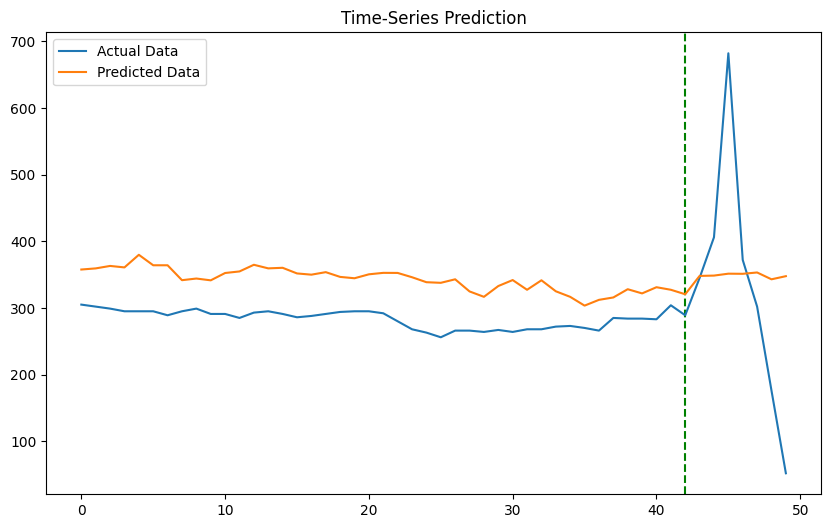

In [58]:
plt.figure(figsize = (10, 6)) 
plt.axvline(x = 42, c = 'g', linestyle = '--')

plt.plot(label_y_final[-50:], label = 'Actual Data')
plt.plot(predicted_final[-50:], label = 'Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

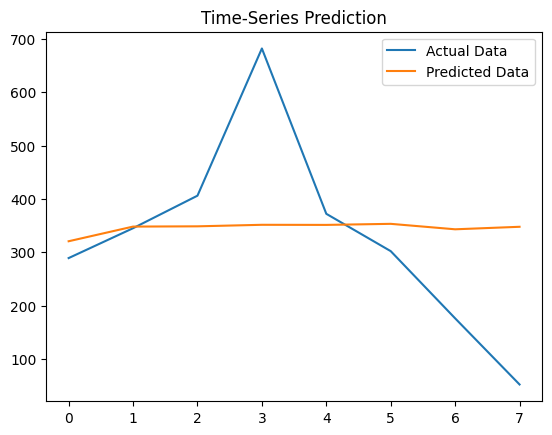

In [56]:
plt.plot(label_y_final[-8:], label = 'Actual Data')
plt.plot(predicted_final[-8:], label = 'Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()